In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import statsmodels.formula.api as sm
import patsy
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV,learning_curve
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.pipeline import Pipeline

In [3]:
job = pd.read_csv('data_job.csv')

# EDA and Features Engineering

In [4]:
job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 9 columns):
Unnamed: 0      3960 non-null int64
Job_Id          3960 non-null object
Job_Title       3960 non-null object
Company         3960 non-null object
Date_Posted     3960 non-null object
Salary          3960 non-null object
Seniority       3960 non-null object
Category        3960 non-null object
Requirements    3960 non-null object
dtypes: int64(1), object(8)
memory usage: 278.5+ KB


In [5]:
job.head()

,Unnamed: 0,Job_Id,Job_Title,Company,Date_Posted,Salary,Seniority,Category,Requirements
0,0,[b' JOB-2019-0090219 '],"[b'Data Engineer (5 days, Orchard, $3500-4000)']",[b'MACHSPEED HUMAN RESOURCES PTE. LTD.'],[b'Posted 27 Apr 2019'],"['/ $3,500to$4,000/ $3,500/ to$4,000/ Monthly/...",[b'Executive'],[b'Information Technology'],['RequirementsRequirements Minimum Degree/Dip...
1,1,[b' JOB-2019-0090314 '],[b'Customer Engagement Excellence Learning Man...,[b'BAYER (SOUTH EAST ASIA) PTE LTD'],[b'Posted 27 Apr 2019'],"['/ $10,400to$15,400/ $10,400/ to$15,400/ Mont...",[b'Manager'],[b'Healthcare / Pharmaceutical'],['Requirements A University / Bachelors degree...
2,2,[b' JOB-2019-0090256 '],"[b'Manager, Research']",[b'GROUP ONE HOLDINGS PTE. LTD.'],[b'Posted 27 Apr 2019'],"['/ $5,000to$8,000/ $5,000/ to$8,000/ Monthly/...",[b'Manager'],[b'Others'],['Requirements·\xa0\xa0\xa0\xa0\xa0\xa0\xa0A s...
3,3,[b' JOB-2019-0090319 '],"[b'Head of Research &amp; Evaluation, Asia']",[b'SAVE THE CHILDREN ASIA REGIONAL OFFICE LIMI...,[b'Posted 27 Apr 2019'],"['/ $80,000to$140,000/ $80,000/ to$140,000/ An...",[b'Middle Management'],[b'General Management'],['RequirementsQualifications 10 plus years ex...
4,4,[b' JOB-2019-0090300 '],[b'IT Systems Adminstrator'],[b'ELIXIR TECHNOLOGY PTE LTD'],[b'Posted 27 Apr 2019'],"['/ $2,800to$3,500/ $2,800/ to$3,500/ Monthly/...",[b'Professional'],[b'Information Technology'],"[""Requirements Bachelor's Degree in Computer S..."


In [6]:
job_clean = job.drop_duplicates(subset='Job_Id', keep='first') #remove duplicate based on Job ID

#drop job Id as it is only use to remove duplicates
job_clean = job_clean.drop(columns=['Job_Id','Unnamed: 0'])
job_clean.shape

(3932, 7)

In [7]:
for col in job_clean.columns:
    job_clean[col]=job_clean[col].str.replace("(\[|\]|b'|Requirements|'|amp;|xa0|\\\|\|xe2x80x93)", "")
job_clean.head()

,Job_Title,Company,Date_Posted,Salary,Seniority,Category,Requirements
0,"Data Engineer (5 days, Orchard, $3500-4000)",MACHSPEED HUMAN RESOURCES PTE. LTD.,Posted 27 Apr 2019,"/ $3,500to$4,000/ $3,500/ to$4,000/ Monthly/ C...",Executive,Information Technology,"Minimum Degree/Diploma in Computer Science, ..."
1,Customer Engagement Excellence Learning Manager,BAYER (SOUTH EAST ASIA) PTE LTD,Posted 27 Apr 2019,"/ $10,400to$15,400/ $10,400/ to$15,400/ Monthl...",Manager,Healthcare / Pharmaceutical,A University / Bachelors degree holder in app...
2,"Manager, Research",GROUP ONE HOLDINGS PTE. LTD.,Posted 27 Apr 2019,"/ $5,000to$8,000/ $5,000/ to$8,000/ Monthly/ C...",Manager,Others,"·A smart communicator, a team player with proa..."
3,"Head of Research & Evaluation, Asia",SAVE THE CHILDREN ASIA REGIONAL OFFICE LIMITED,Posted 27 Apr 2019,"/ $80,000to$140,000/ $80,000/ to$140,000/ Annu...",Middle Management,General Management,Qualifications 10 plus years expertise and do...
4,IT Systems Adminstrator,ELIXIR TECHNOLOGY PTE LTD,Posted 27 Apr 2019,"/ $2,800to$3,500/ $2,800/ to$3,500/ Monthly/ C...",Professional,Information Technology,""" Bachelors Degree in Computer Science, Comput..."


In [8]:
#check for row with missing job title
job_clean[job_clean['Job_Title'] == '']

,Job_Title,Company,Date_Posted,Salary,Seniority,Category,Requirements
27,,,,,,,


In [9]:
empty = job_clean['Job_Title'] == ''

In [10]:
#remove row without job title
job_clean = job_clean[~empty]

In [11]:
#remove row without salary
no_salary = job_clean['Salary'].str.contains('Salary undisclosed')

In [12]:
job_clean_df = job_clean[~no_salary]

In [13]:
#extract salary into min/max/type category
salary_range = job_clean_df["Salary"].str.split("/", n = 5, expand = True) 

In [14]:
salary_range.head()

,0,1,2,3,4,5
0,,"$3,500to$4,000","$3,500","to$4,000",Monthly,Closing on 27 May 2019
1,,"$10,400to$15,400","$10,400","to$15,400",Monthly,Closing on 12 May 2019
2,,"$5,000to$8,000","$5,000","to$8,000",Monthly,Closing on 27 May 2019
3,,"$80,000to$140,000","$80,000","to$140,000",Annually,Closing on 11 May 2019
4,,"$2,800to$3,500","$2,800","to$3,500",Monthly,Closing on 27 May 2019


In [15]:
salary_range = salary_range.rename({0:'recruiter',1:'range', 2:'min', 3:'max', 4:'type'}, axis='columns')

In [16]:
min_max = salary_range['range'].str.split('to', n=2, expand = True)

In [17]:
min_max = min_max.rename({0:'sal_min', 1:'sal_max'}, axis='columns')

In [18]:
salary_range = pd.concat([salary_range, min_max], axis=1)

In [19]:
salary_range.shape

(3472, 8)

In [20]:
#removed $ and 'to' from salary 
for col in salary_range.columns:
    salary_range[col]=salary_range[col].str.replace('(\$|,|to)', '')
salary_range.head()

,recruiter,range,min,max,type,5,sal_min,sal_max
0,,35004000,3500,4000,Monthly,Closing on 27 May 2019,3500,4000
1,,1040015400,10400,15400,Monthly,Closing on 12 May 2019,10400,15400
2,,50008000,5000,8000,Monthly,Closing on 27 May 2019,5000,8000
3,,80000140000,80000,140000,Annually,Closing on 11 May 2019,80000,140000
4,,28003500,2800,3500,Monthly,Closing on 27 May 2019,2800,3500


In [21]:
#data from job posted by recruiter are shifted to the right
#salary min falls under max and salary max falls under type
salary_range[salary_range['recruiter'].str.contains('Recruiter')].head()

,recruiter,range,min,max,type,5,sal_min,sal_max
53,via Recruiter,,25003200,2500,3200,Monthly/ Closing on 26 May 2019,,None
72,Recruiter,,30005000,3000,5000,Monthly/ Closing on 26 May 2019,,None
96,via Recruiter,,18002600,1800,2600,Monthly/ Closing on 26 May 2019,,None
99,via Recruiter,,63006800,6300,6800,Monthly/ Closing on 26 May 2019,,None
103,via Recruiter,,780012200,7800,12200,Monthly/ Closing on 10 May 2019,,None


In [22]:
#adjust salary min and max for recruiter data
salary_range.loc[salary_range['recruiter'].str.contains('Recruiter'), 'sal_min'] = salary_range['max']
salary_range.loc[salary_range['recruiter'].str.contains('Recruiter'), 'sal_max'] = salary_range['type']

In [23]:
#convert from ojbect to float 
salary_range['sal_min'] = salary_range['sal_min'].astype('float64')
salary_range['sal_max'] = salary_range['sal_max'].astype('float64')

In [24]:
salary_range.describe()

,sal_min,sal_max
count,3472.000000,3472.000000
mean,7215.020449,11079.663882
std,15684.739939,23760.781468
min,1.000000,2.000000
25%,2800.000000,4000.000000
50%,4100.000000,6800.000000
75%,6500.000000,10000.000000
max,280000.000000,405000.000000


In [25]:
abovemean = 3*np.mean(salary_range['sal_min'])

In [26]:
salary_range[((salary_range['recruiter'].str.contains('Recruiter')) & (salary_range['sal_min'] > abovemean))]

,recruiter,range,min,max,type,5,sal_min,sal_max
428,Recruiter,,110000180000,110000,180000,Annually/ Closing on 24 May 2019,110000.0,180000.0
1859,Recruiter,,7000080000,70000,80000,Annually/ Closing on 15 May 2019,70000.0,80000.0


In [27]:
#assume sal_min 3x above mean is Annually type of salary the rest are Monthly type
salary_range.loc[((salary_range['recruiter'].str.contains('Recruiter')) & (salary_range['sal_min'] > abovemean)), 'type'] = ' Annually'
salary_range.loc[((salary_range['recruiter'].str.contains('Recruiter')) & (salary_range['sal_min'] < abovemean)), 'type'] = ' Monthly'

In [28]:
#only keep relevent columns before merge back
salary_range = salary_range.drop(columns=['range','min','max',5])

In [29]:
job_df = pd.concat([job_clean_df, salary_range], axis=1)

In [30]:
#drop original salary columns and job date due to feature not useful for prediction
job_df = job_df.drop(columns=['Date_Posted','Salary','recruiter'])

In [31]:
#assuming typo for sal_max 10 times more than sal_min. To correct value by sal_max divided by 10
job_df.loc[(job_df['sal_max']>10*job_df['sal_min']), 'sal_max'] = job_df['sal_max']/10

In [32]:
#standardize all salary type to Monthly
job_df.loc[job_df['type'].str.contains(' Annually'), 'sal_min'] = round(job_df['sal_min']/12)
job_df.loc[job_df['type'].str.contains(' Annually'), 'sal_max'] = round(job_df['sal_max']/12)
job_df = job_df.drop(columns='type')

In [33]:
col = job_df.columns

In [34]:
#further remove job with same data from all columns
job_df = job_df.drop_duplicates(subset=col, keep='first')

In [35]:
#further filter on job title with specific data job keywords
title_key = ['DATA', 'MACHINE','ANALYST','MACHINE LEARNING','ANALYTICS','DEEP LEARNING','RESEARCH','NLP']
key = '|'.join(title_key)
data_job = job_df['Job_Title'].str.upper().str.contains(key)
job_df = job_df[data_job]

In [36]:
#to drop job with max salary less than 2000, assuming data entry/admin/operator job
mask_low = job_df['sal_max']<=2000
job_df = job_df[~mask_low]

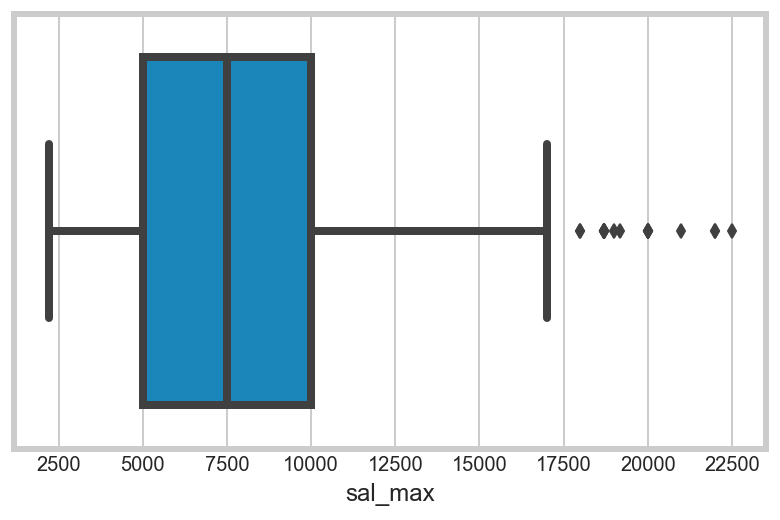

In [37]:
sns.boxplot(job_df['sal_max'])

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


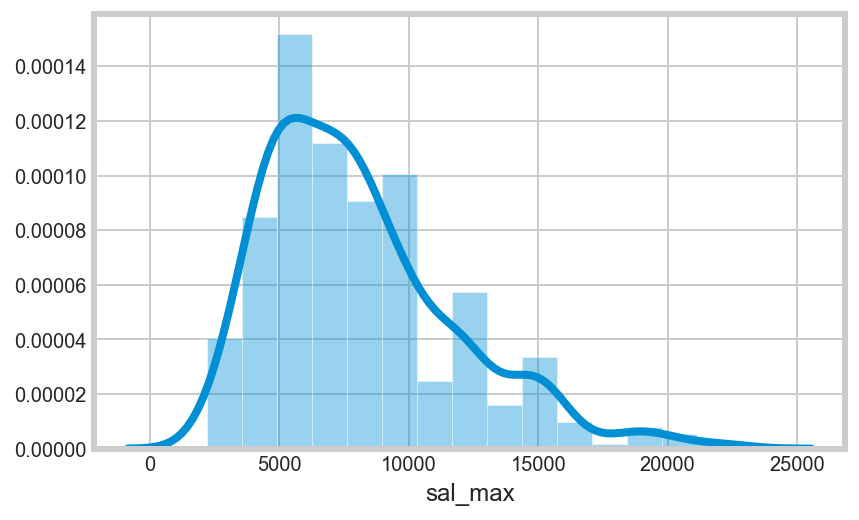

In [38]:
sns.distplot(job_df['sal_max'], bins=15);

In [39]:
#create new feature for average salary
job_df['Avg Salary'] = (job_df['sal_min'] + job_df['sal_max']) / 2

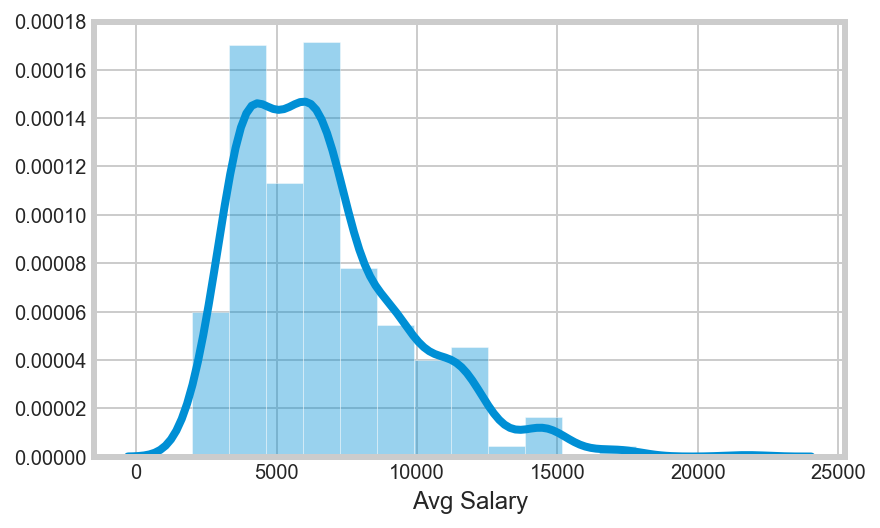

In [40]:
sns.distplot(job_df['Avg Salary'], bins=15);

### create label for high and low salary according to median salary.

In [41]:
job_df["sal_high"] = job_df['Avg Salary'].map(lambda x: 1 if x >= np.median(job_df['Avg Salary']) else 0)
job_df["sal_high"].value_counts()

1    450
0    388
Name: sal_high, dtype: int64

In [42]:
#baseline model at 53% due to salary cut-off at median
baseline = np.mean(job_df["sal_high"])
baseline

0.5369928400954654

In [43]:
job_df = job_df.reset_index(drop=True)

In [72]:
#check seniority with multiple rank
job_df[job_df['Seniority'].str.count(',')>=2].head()

,Job_Title,Company,Seniority,Category,Requirements,sal_min,sal_max,Avg Salary,sal_high,Executive,Fresh/entry level,Junior Executive,Manager,Middle Management,Non-executive,Professional,Senior Executive,Senior Management


In [45]:
job_df['Seniority'] = job_df['Seniority'].str.split(', ')

In [46]:
#job posted with more than 2 seniority classify under multiple,
#second seniority is taken as value for job with 2 seniority 
job_df['Seniority'] = job_df['Seniority'].map(lambda x: x[0] if len(x)>2 else (x[1] if len(x)>1 else x[0]))

In [47]:
job_df['Seniority'].value_counts()

Professional         233
Executive            198
Senior Executive     109
Non-executive         79
Manager               60
Junior Executive      54
Fresh/entry level     41
Middle Management     38
Senior Management     26
Name: Seniority, dtype: int64

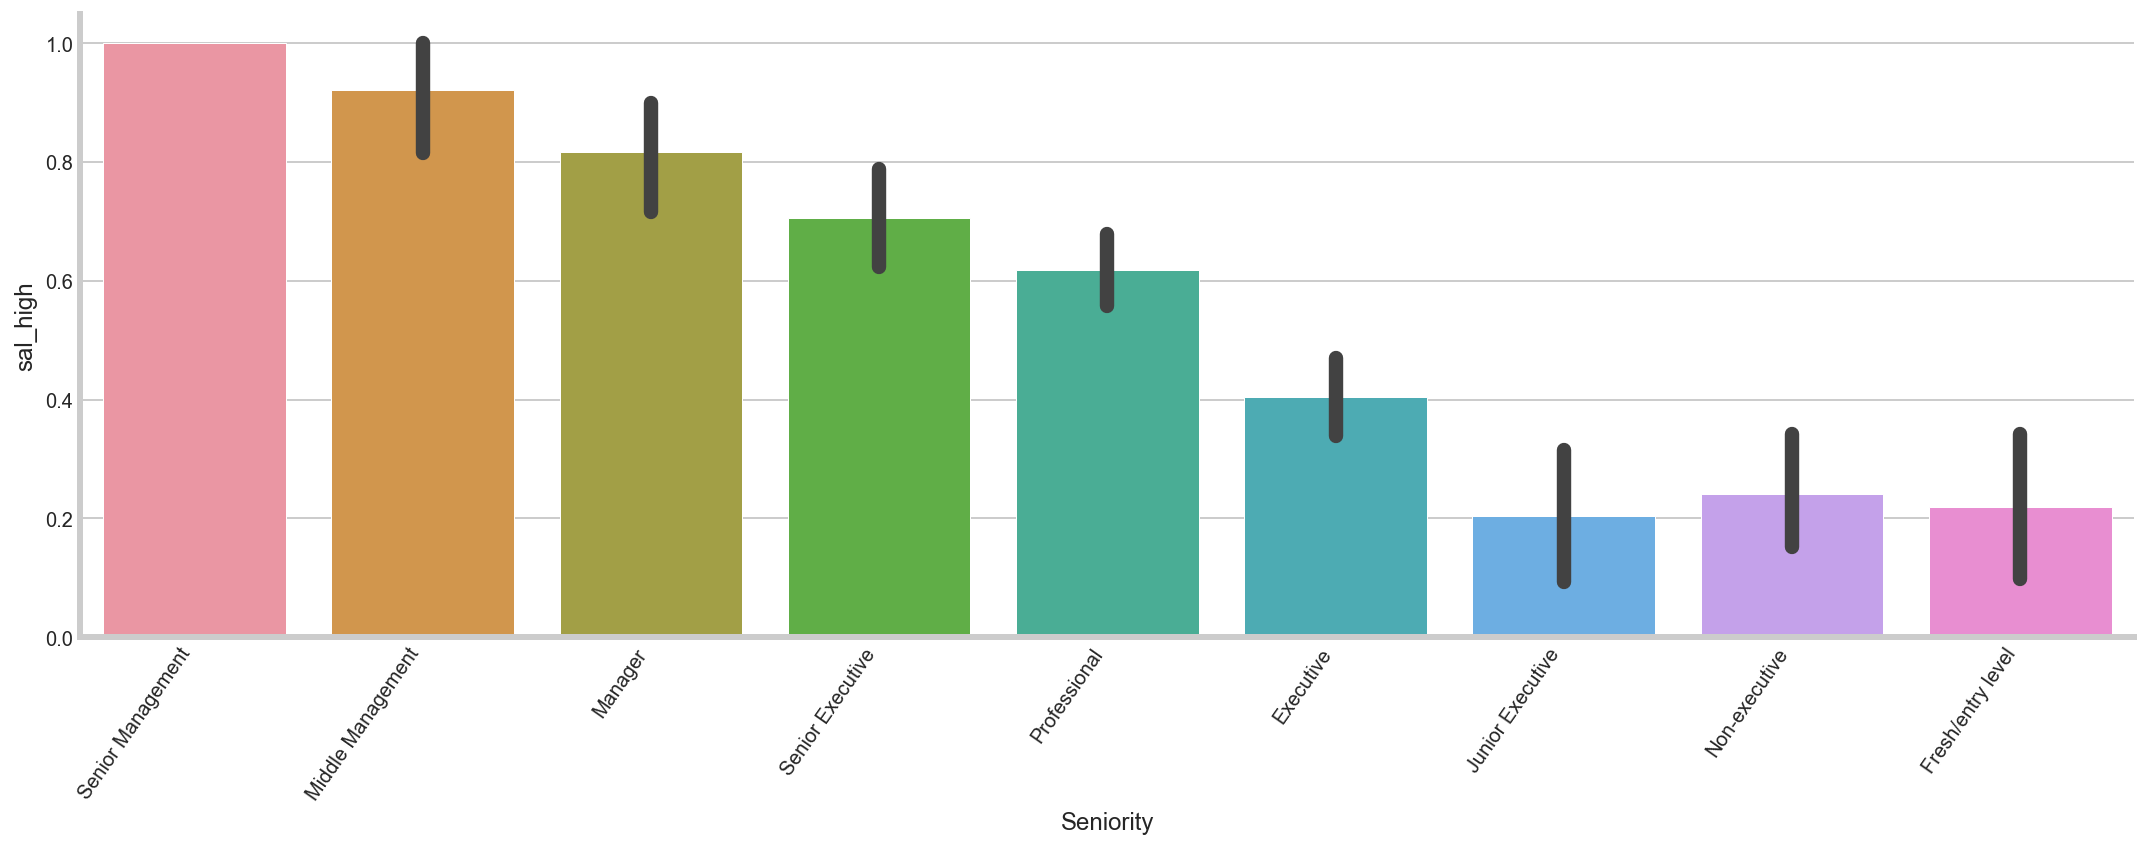

In [48]:
senior_order = ('Senior Management', 'Middle Management', 'Manager','Senior Executive',
                'Professional','Executive', 'Junior Executive','Non-executive','Fresh/entry level')

sns.catplot(x='Seniority', y='sal_high',data=job_df, kind='bar', aspect=3, 
               order=senior_order).set_xticklabels(rotation=55, horizontalalignment='right')
plt.show();

In [49]:
seniority_cat=job_df['Seniority'].str.get_dummies()
seniority_cat.head()

,Executive,Fresh/entry level,Junior Executive,Manager,Middle Management,Non-executive,Professional,Senior Executive,Senior Management
0,1,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0


In [50]:
job_df = pd.concat([job_df, seniority_cat], axis=1)

In [51]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from nltk.corpus import stopwords

In [52]:
stop = stopwords.words('english')
stop += ['regret','shortlisted', 'candidates','notified','etc']
#stop += ['regret', 'shortlisted', 'candidates', 'notified','least','skills',
#         'related','good','years','added','able','advantage','work','etc',
#         'working','ability','excellent','year','knowledge']

In [53]:
def get_freq_words(sparse_counts, columns):
    # X_all is a sparse matrix, so sum() returns a 'matrix' datatype ...
    #   which we then convert into a 1-D ndarray for sorting
    word_counts = np.asarray(X_all.sum(axis=0)).reshape(-1)

    # argsort() returns smallest first, so we reverse the result
    largest_count_indices = word_counts.argsort()[::-1]
    freq_words = pd.Series(word_counts[largest_count_indices], 
                           index=columns[largest_count_indices])

    return freq_words

In [54]:
#most common words for requirements
cvt      =  CountVectorizer(strip_accents='unicode', ngram_range=(1,2), stop_words=stop, min_df=5)
X_all    =  cvt.fit_transform(job_df['Requirements'])
columns  =  np.array(cvt.get_feature_names()) 

freq_words = get_freq_words(X_all, columns)
freq_words_percent = freq_words/len(job_df['Requirements'])
freq_words[:20]

experience       2255
data             1637
skills           1268
knowledge         719
ability           692
strong            681
years             593
work              567
business          522
management        511
working           496
good              486
degree            477
science           442
computer          422
communication     417
team              410
excellent         364
sql               328
related           318
dtype: int64

In [55]:
#most common ngrams for requirements
cvt = CountVectorizer(stop_words=stop, ngram_range=(2,2))
X_all = cvt.fit_transform(job_df['Requirements'])
columns  =  np.array(cvt.get_feature_names())

freq_words = get_freq_words(X_all, columns)
freq_words[:10]

computer science        291
communication skills    267
machine learning        201
years experience        196
problem solving         168
ability work            157
big data                149
experience working      143
skills ability          142
team player             130
dtype: int64

In [56]:
tfid = TfidfVectorizer(stop_words=stop, ngram_range=(2,2))
X_all = tfid.fit_transform(job_df['Requirements'])
columns  =  np.array(tfid.get_feature_names())

freq_words = get_freq_words(X_all, columns)
freq_words[:10]

computer science        12.177185
communication skills    11.285294
machine learning        10.443771
years experience         9.049228
least years              7.604022
ability work             7.488082
problem solving          7.331416
experience working       7.250896
big data                 7.199579
team player              7.186408
dtype: float64

In [57]:
cvec = CountVectorizer(lowercase=True, strip_accents='unicode', stop_words=stop,ngram_range=(1,3))
cvec.fit(job_df['Requirements'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...'t", 'won', "won't", 'wouldn', "wouldn't", 'regret', 'shortlisted', 'candidates', 'notified', 'etc'],
        strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [58]:
model_data = job_df.drop(columns=['Job_Title','Company','Seniority','Category','sal_min','sal_max','Avg Salary'])

In [59]:
nlp = pd.DataFrame(cvec.transform(model_data['Requirements']).todense(),
                       columns=cvec.get_feature_names())

In [60]:
senior_nlp = pd.concat([model_data, nlp], axis=1)
senior_nlp.shape

(838, 94069)

In [61]:
X = senior_nlp.drop(columns=['sal_high','Requirements'])
y = senior_nlp['sal_high'].values

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
lr = LogisticRegression(penalty='l2',solver='lbfgs') #with ridge regularization 
lr.fit(X_train, y_train)
predicted = lr.predict(X_test)

#print('Cross val score on train data:', np.mean(cross_val_score(lr, X_train, y_train, cv=5)))
#print('Accuracy on test data:',accuracy_score(y_test,predicted))
print('AUC score on test data',roc_auc_score(y_test,lr.predict_proba(X_test)[:,1]))
print('AUC score on train data',roc_auc_score(y_train,lr.predict_proba(X_train)[:,1]))

AUC score on test data 0.8358422939068101
AUC score on train data 0.9998075907679366


In [64]:
pd.DataFrame(confusion_matrix(y_test,lr.predict(X_test)),
             index=['Actual Low Salary','Actual High Salary'],
             columns=['Predicted Low Salary','Predicted High Salary'])

,Predicted Low Salary,Predicted High Salary
Actual Low Salary,55,20
Actual High Salary,26,67


In [65]:
features = np.array(X_train.columns)
lr_coefs = pd.DataFrame({'coef':lr.coef_[0], 'abs coef':abs(lr.coef_[0])},index=features)
lr_coefs = lr_coefs.sort_values('abs coef',ascending=False)
lr_coefs.head(10)

,coef,abs coef
Middle Management,0.980247,0.980247
Non-executive,-0.882289,0.882289
phd,0.609741,0.609741
diploma,-0.514388,0.514388
Executive,-0.503971,0.503971
engineering,-0.492144,0.492144
Fresh/entry level,-0.463113,0.463113
Professional,0.453173,0.453173
fresh,-0.431829,0.431829
Junior Executive,-0.421649,0.421649


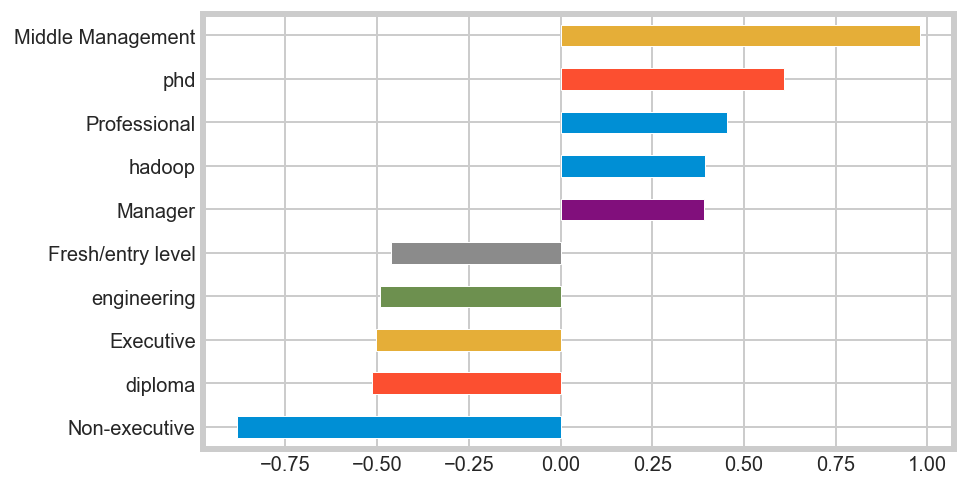

In [66]:
imp_coefs = pd.concat([lr_coefs.sort_values('coef',ascending = True).head(5),
                     lr_coefs.sort_values('coef',ascending = True).tail(5)])
imp_coefs['coef'].plot(kind = "barh")

In [67]:
from sklearn.ensemble import AdaBoostClassifier

Ada = AdaBoostClassifier() #with ridge regularization 

Ada.fit(X_train, y_train)
predicted = Ada.predict(X_test)
#print('Model score on test data:',Ada.score(X_test, y_test))
print('AUC score on test data:',roc_auc_score(y_test,Ada.predict_proba(X_test)[:,1]))
print('AUC score on train data:',roc_auc_score(y_train,Ada.predict_proba(X_train)[:,1]))

AUC score on test data: 0.7969175627240143
AUC score on train data: 0.9597461987990084


In [68]:
pd.DataFrame(confusion_matrix(y_test,Ada.predict(X_test)),
             index=['Actual Low Salary','Actual High Salary'],
             columns=['Predicted Low Salary','Predicted High Salary'])

,Predicted Low Salary,Predicted High Salary
Actual Low Salary,48,27
Actual High Salary,20,73


In [69]:
features = np.array(X_train.columns)
Ada_coefs = pd.DataFrame({'coef':Ada.feature_importances_},index=features)
Ada_coefs.head(10)

,coef
Executive,0.02
Fresh/entry level,0.02
Junior Executive,0.02
Manager,0.02
Middle Management,0.02
Non-executive,0.02
Professional,0.00
Senior Executive,0.00
Senior Management,0.02
00,0.00


In [78]:
#logistic regression model and ada boost model top 10 features
Ada_feat = Ada_coefs.head(10).index
Logit_reg = lr_coefs.head(10).index
sal_features = pd.DataFrame({'AdaBoost model':Ada_feat, 'Logistic model':Logit_reg})
sal_features

,AdaBoost model,Logistic model
0,Executive,Middle Management
1,Fresh/entry level,Non-executive
2,Junior Executive,phd
3,Manager,diploma
4,Middle Management,Executive
5,Non-executive,engineering
6,Professional,Fresh/entry level
7,Senior Executive,Professional
8,Senior Management,fresh
9,00,Junior Executive


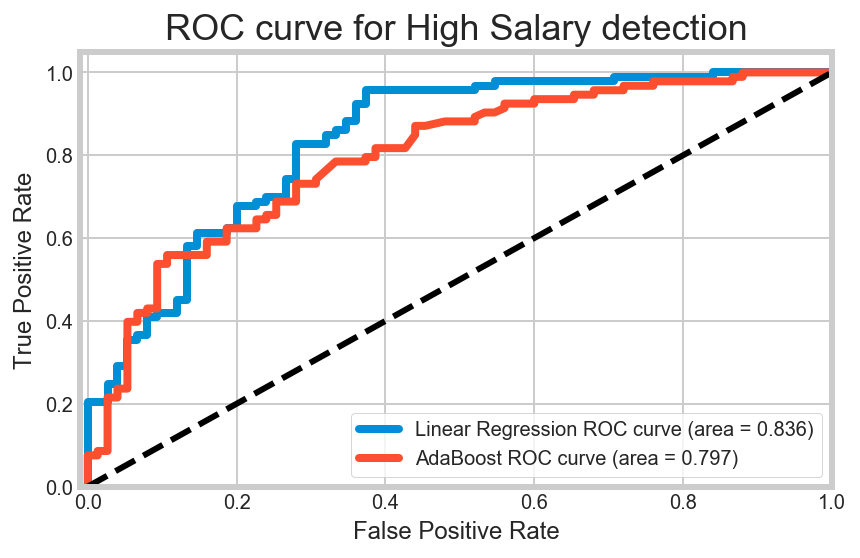

In [79]:
#logistic regression model and ada boost model ROC curve

y_score_lr = lr.predict_proba(X_test)[:,1]
y_score_ada = Ada.predict_proba(X_test)[:,1]
FPR1, TPR1, THR1 = roc_curve(y_test,y_score_lr)
FPR2, TPR2, THR2 = roc_curve(y_test,y_score_ada)
ROC_AUC1=auc(FPR1,TPR1)
ROC_AUC2=auc(FPR2,TPR2)

plt.plot(FPR1, TPR1, label='Linear Regression ROC curve (area = %0.3f)' % ROC_AUC1, linewidth=4)
plt.plot(FPR2, TPR2, label='AdaBoost ROC curve (area = %0.3f)' % ROC_AUC2, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve for High Salary detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()